## import some stuff ##

In [228]:
import numpy as np
import scipy as sc
from pandas import Series,DataFrame
import pandas as pd

from scipy import spatial
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from collections import OrderedDict
from fractions import Fraction

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10.0, 5)

# Part 1 #
## Collaborative filtering item-item ##


This notebook is implementation of collaborative filtering algorithm in python.
Missing rating for Hotel1, and User5 is going to be predicted. 
Recommendations are maid based on these calculations.

Have fun...

In [229]:
df = pd.DataFrame({'Hotel1' :[1,0,3,0,0,5,0,0,5,0,4,0],
                   'Hotel2' :[0,0,5,4,0,0,4,0,0,2,1,3],
                   'Hotel3' :[2,4,0,1,2,0,3,0,4,3,5,0],
                   'Hotel4' :[0,2,4,0,5,0,0,4,0,0,2,0],
                   'Hotel5' :[0,0,4,3,4,2,0,0,0,0,2,5],
                   'Hotel6' : [1,0,3,0,3,0,0,2,0,0,4,0],
                   }, index=['User1','User2','User3','User4','User5',
                             'User6','User7','User8','User9','User10','User11','User12'])
df = df.transpose()
df

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,User11,User12
Hotel1,1,0,3,0,0,5,0,0,5,0,4,0
Hotel2,0,0,5,4,0,0,4,0,0,2,1,3
Hotel3,2,4,0,1,2,0,3,0,4,3,5,0
Hotel4,0,2,4,0,5,0,0,4,0,0,2,0
Hotel5,0,0,4,3,4,2,0,0,0,0,2,5
Hotel6,1,0,3,0,3,0,0,2,0,0,4,0


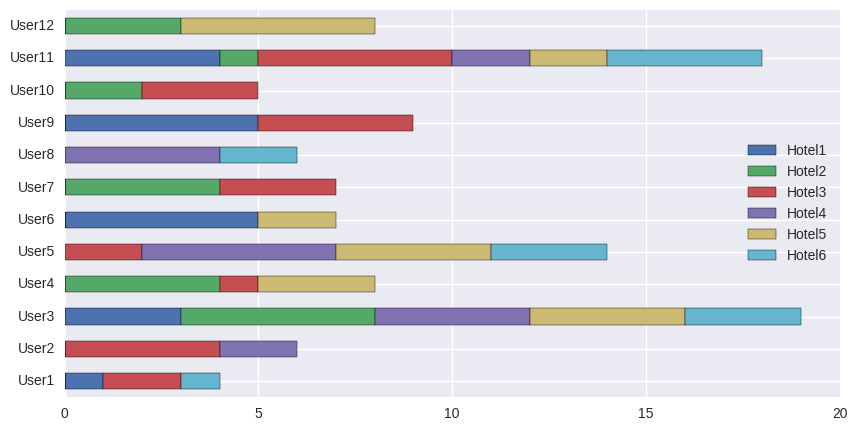

In [230]:
# check if hotels have enough ratings (enough support) to be able to make predictions
df.transpose().plot.barh(stacked=True)

In [231]:
# find 0 values
no_rating_mask = (df == 0)
no_rating_mask

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,User11,User12
Hotel1,False,True,False,True,True,False,True,True,False,True,False,True
Hotel2,True,True,False,False,True,True,False,True,True,False,False,False
Hotel3,False,False,True,False,False,True,False,True,False,False,False,True
Hotel4,True,False,False,True,False,True,True,False,True,True,False,True
Hotel5,True,True,False,False,False,False,True,True,True,True,False,False
Hotel6,False,True,False,True,False,True,True,False,True,True,False,True


In [232]:
#comes after
#df[no_rating_mask] = None
#df

In [233]:
# possibility 2 to find hotel rating mean values
hotel_rating_averages = df[np.invert(no_rating_mask)].mean(axis=1)
hotel_rating_averages

Hotel1    3.600000
Hotel2    3.166667
Hotel3    3.000000
Hotel4    3.400000
Hotel5    3.333333
Hotel6    2.600000
dtype: float64

In [234]:
# normalise dataset
dfn = df.sub(hotel_rating_averages, axis=0)
dfn = dfn.round(1)
dfn

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,User11,User12
Hotel1,-2.6,-3.6,-0.6,-3.6,-3.6,1.4,-3.6,-3.6,1.4,-3.6,0.4,-3.6
Hotel2,-3.2,-3.2,1.8,0.8,-3.2,-3.2,0.8,-3.2,-3.2,-1.2,-2.2,-0.2
Hotel3,-1.0,1.0,-3.0,-2.0,-1.0,-3.0,0.0,-3.0,1.0,0.0,2.0,-3.0
Hotel4,-3.4,-1.4,0.6,-3.4,1.6,-3.4,-3.4,0.6,-3.4,-3.4,-1.4,-3.4
Hotel5,-3.3,-3.3,0.7,-0.3,0.7,-1.3,-3.3,-3.3,-3.3,-3.3,-1.3,1.7
Hotel6,-1.6,-2.6,0.4,-2.6,0.4,-2.6,-2.6,-0.6,-2.6,-2.6,1.4,-2.6


In [235]:
# put 0 values where no values was found
dfn[no_rating_mask] = 0
# and round values
dfn = dfn.round(1)

In [236]:
dfn

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,User11,User12
Hotel1,-2.6,0.0,-0.6,0.0,0.0,1.4,0.0,0.0,1.4,0.0,0.4,0.0
Hotel2,0.0,0.0,1.8,0.8,0.0,0.0,0.8,0.0,0.0,-1.2,-2.2,-0.2
Hotel3,-1.0,1.0,0.0,-2.0,-1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0
Hotel4,0.0,-1.4,0.6,0.0,1.6,0.0,0.0,0.6,0.0,0.0,-1.4,0.0
Hotel5,0.0,0.0,0.7,-0.3,0.7,-1.3,0.0,0.0,0.0,0.0,-1.3,1.7
Hotel6,-1.6,0.0,0.4,0.0,0.4,0.0,0.0,-0.6,0.0,0.0,1.4,0.0


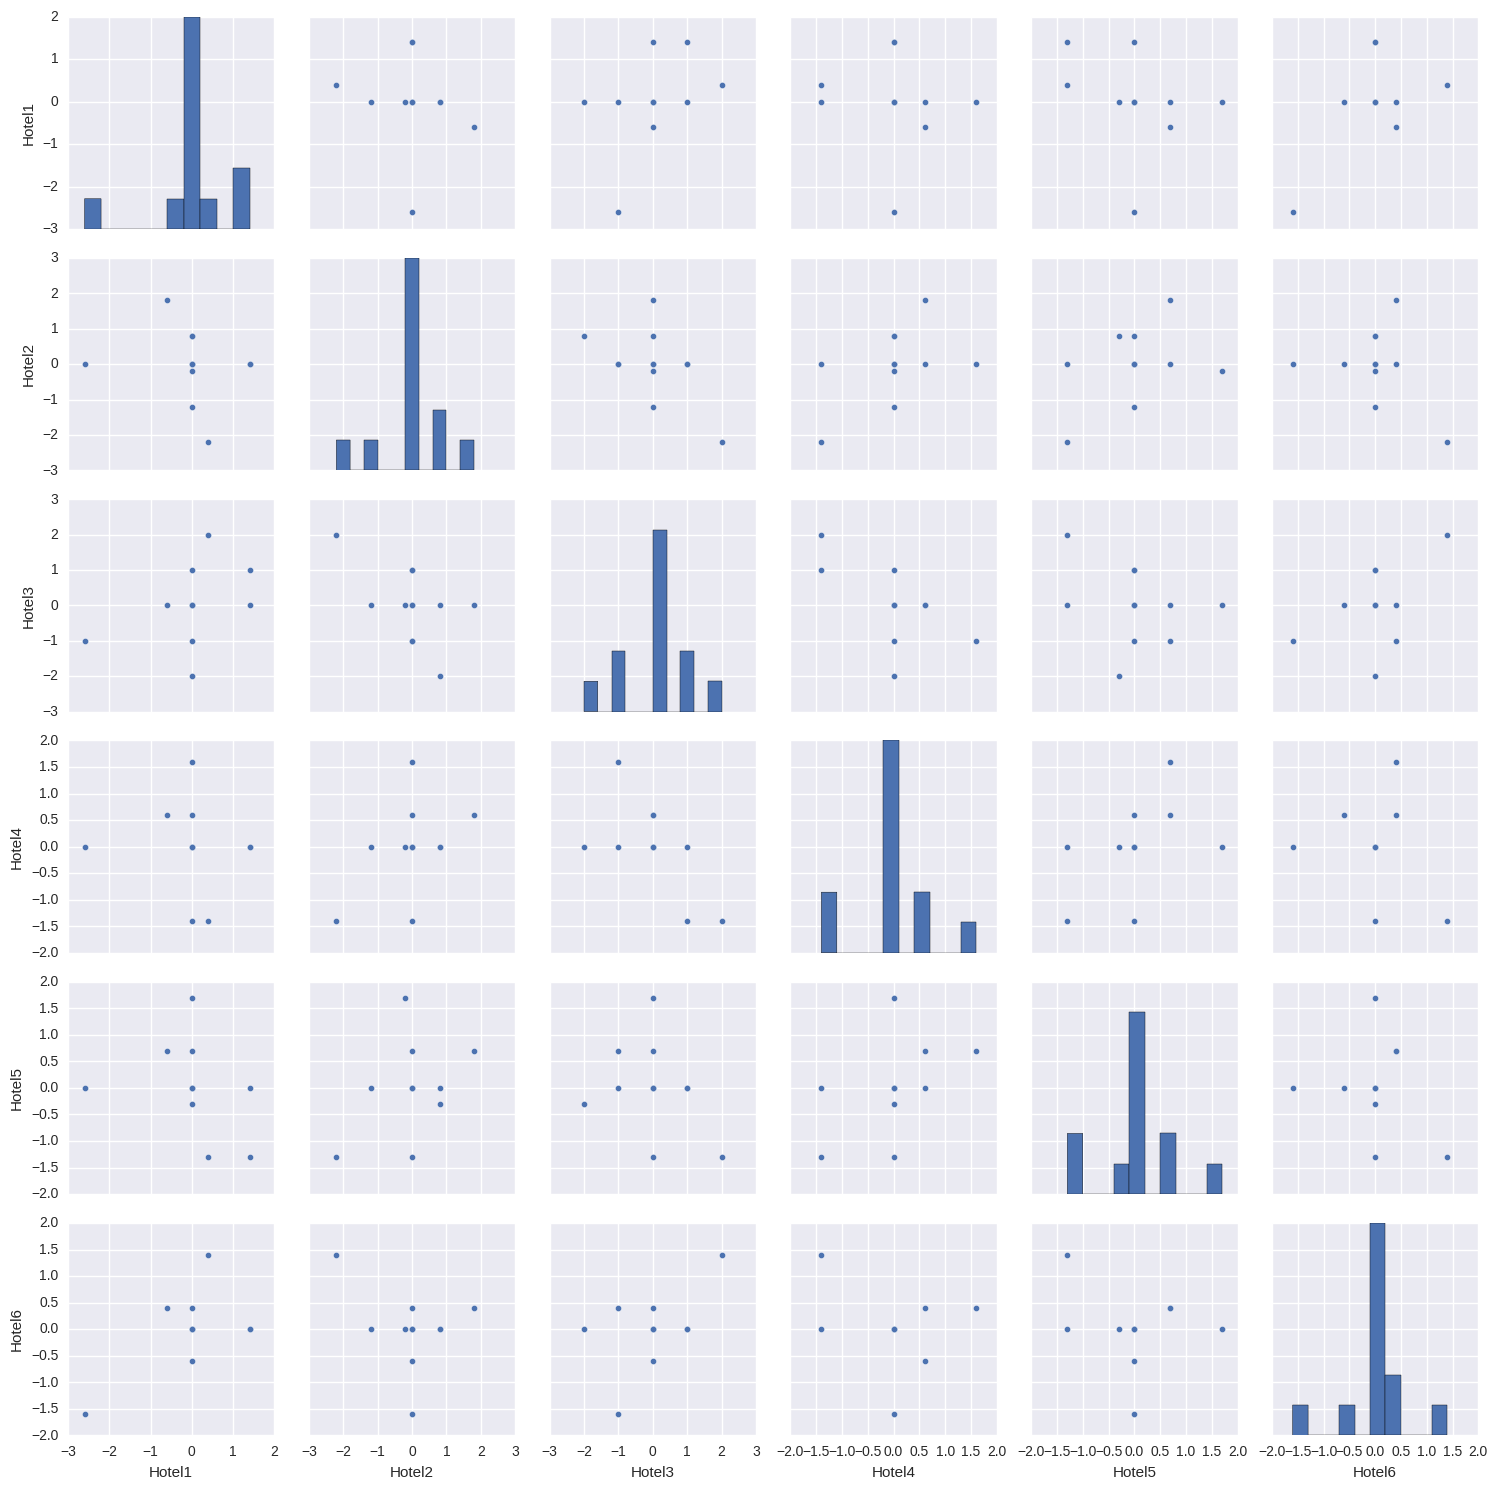

In [237]:
# inspect hotel similarities 
sns.pairplot(dfn.transpose())

[(-2.6000000000000001, 0.0, -0.59999999999999998, 0.0, 0.0, 1.3999999999999999, 0.0, 0.0, 1.3999999999999999, 0.0, 0.40000000000000002, 0.0), (0.0, 0.0, 1.8, 0.80000000000000004, 0.0, 0.0, 0.80000000000000004, 0.0, 0.0, -1.2, -2.2000000000000002, -0.20000000000000001), (-1.0, 1.0, 0.0, -2.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0), (0.0, -1.3999999999999999, 0.59999999999999998, 0.0, 1.6000000000000001, 0.0, 0.0, 0.59999999999999998, 0.0, 0.0, -1.3999999999999999, 0.0), (0.0, 0.0, 0.69999999999999996, -0.29999999999999999, 0.69999999999999996, -1.3, 0.0, 0.0, 0.0, 0.0, -1.3, 1.7), (-1.6000000000000001, 0.0, 0.40000000000000002, 0.0, 0.40000000000000002, 0.0, 0.0, -0.59999999999999998, 0.0, 0.0, 1.3999999999999999, 0.0)]


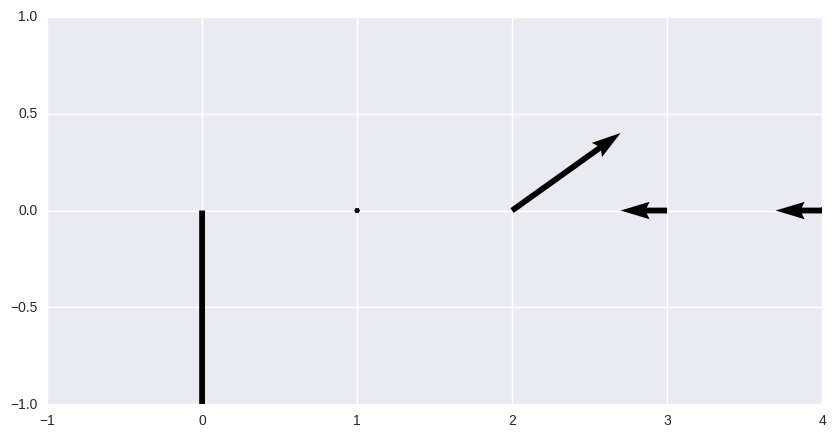

In [238]:
# we could also plot hotel recommendation values vectors 
soa = dfn.transpose().values
print zip(*soa)
X,Y,U,V,Z,E = zip(*soa)
plt.figure()
ax = plt.gca()
ax.quiver(X,Y,U,V,Z,E, angles='xy',scale_units='xy',scale=1)
ax.set_xlim([-1,4])
ax.set_ylim([-1,1])
plt.draw()
plt.show()

In [239]:
# pearson correlation similarity
# option 1
hotel_similarity_df = dfn.transpose().corr().round(2)
hotel_similarity_df

,Hotel1,Hotel2,Hotel3,Hotel4,Hotel5,Hotel6
Hotel1,1.00,-0.18,0.41,-0.10,-0.30,0.59
Hotel2,-0.18,1.00,-0.53,0.47,0.40,-0.31
Hotel3,0.41,-0.53,1.00,-0.62,-0.29,0.51
Hotel4,-0.10,0.47,-0.62,1.00,0.46,-0.24
Hotel5,-0.30,0.40,-0.29,0.46,1.00,-0.20
Hotel6,0.59,-0.31,0.51,-0.24,-0.20,1.00


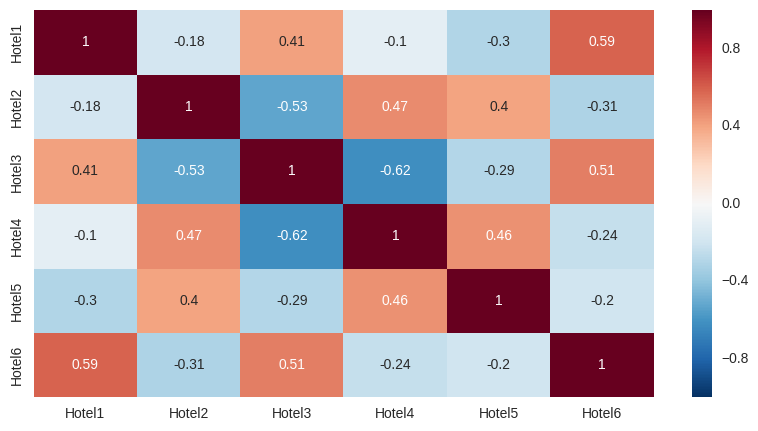

In [240]:
sns.heatmap(hotel_similarity_df, annot=True)

In [241]:
# we couuld also calculate hotel similarities this way
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

A_sparse = sparse.csr_matrix(dfn.as_matrix())

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse, dense_output=False)
print('hotel pairwise similarity:\n {}\n'.format(similarities_sparse))

hotel pairwise similarity:
   (0, 4)	-0.30440518162
  (0, 3)	-0.102450142733
  (0, 1)	-0.177882170047
  (0, 5)	0.587039508564
  (0, 2)	0.414039335605
  (0, 0)	1.0
  (1, 2)	-0.526072967874
  (1, 5)	-0.314337134669
  (1, 4)	0.396862981681
  (1, 3)	0.470882381601
  (1, 1)	1.0
  (1, 0)	-0.177882170047
  (2, 4)	-0.287690228501
  (2, 1)	-0.526072967874
  (2, 3)	-0.623980650222
  (2, 5)	0.506369683542
  (2, 2)	1.0
  (2, 0)	0.414039335605
  (3, 5)	-0.235339362166
  (3, 4)	0.46219474056
  (3, 1)	0.470882381601
  (3, 0)	-0.102450142733
  (3, 3)	1.0
  (3, 2)	-0.623980650222
  (4, 2)	-0.287690228501
  (4, 5)	-0.20394865395
  (4, 4)	1.0
  (4, 3)	0.46219474056
  (4, 1)	0.396862981681
  (4, 0)	-0.30440518162
  (5, 4)	-0.20394865395
  (5, 3)	-0.235339362166
  (5, 1)	-0.314337134669
  (5, 5)	1.0
  (5, 2)	0.506369683542
  (5, 0)	0.587039508564



# now lets calculate how would the user 5 rate the hotel 1

In [242]:
# Hotel1 is most similar to the Hotels 3 and 6
mask = hotel_similarity_df["Hotel1"] > 0.30
mask

Hotel1     True
Hotel2    False
Hotel3     True
Hotel4    False
Hotel5    False
Hotel6     True
Name: Hotel1, dtype: bool

In [243]:
# take ratings of most similar hotels (3 and 6)
hotel_ratings = df.User5[mask].values[1:]
hotel_ratings

array([2, 3])

In [244]:
# take similarities of most similar hotels (3 and 6)
hotel_sim = hotel_similarity_df.Hotel1[mask].values[1:]
hotel_sim

array([ 0.41,  0.59])

In [245]:
#calculate rating for hotel 1 from user 5
# predict by taking weighted average
r_15 = sum(mov_ratings * mov_sim) / sum(mov_sim)
print "User 5 would rate Hotel 1 with: ", round(r_15,1), " stars"

User 5 would rate Hotel 1 with:  2.6  stars
